In [1]:
import copy
import json
import os
import re
import shutil
import sys
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
import tifffile
import yaml
from einops import rearrange, repeat
from ome_types import from_xml, to_xml
from ome_types.model import OME, Image, Pixels, Channel
from skimage.transform import rescale, resize

In this notebook I'll be covering how to annotate and view a path in a stacked 3D registered dataset.

We'll be starting with the registration performed in the [serial section registration notebook](https://github.com/estorrs/ding-lab-spatial/blob/main/3d_analysis/serial_section_registration.ipynb).

In [2]:
registered_dir = Path('../data/registration_example/registered')

# these are all the registered data files
sorted(registered_dir.rglob('*'))

[PosixPath('../data/registration_example/registered/Z0_HT891Z1-U1_xenium.h5ad'),
 PosixPath('../data/registration_example/registered/Z0_HT891Z1-U1_xenium_morphology.ome.tiff'),
 PosixPath('../data/registration_example/registered/Z0_HT891Z1-U1_xenium_transcripts.parquet'),
 PosixPath('../data/registration_example/registered/Z10_HT891Z1-U4_he.ome.tiff'),
 PosixPath('../data/registration_example/registered/Z5_HT891Z1-U2_he.ome.tiff'),
 PosixPath('../data/registration_example/registered/Z5_HT891Z1-U2_visiumhd.h5ad'),
 PosixPath('../data/registration_example/registered/Z65_HT891Z1-U14_multiplex.ome.tiff'),
 PosixPath('../data/registration_example/registered/config.json')]

Setting an output directory

In [3]:
path_annot_dir = Path('../data/registration_example/path_annotation')
Path(path_annot_dir).mkdir(parents=True, exist_ok=True)

Reading in the data map

In [4]:
data_map = pd.read_csv('HT891Z1_sections.txt', sep='\t')
data_map

,section_id,position,dtype,filepath,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,HT891Z1-U1,0,xenium,/diskmnt/primary/Xenium/data/20240524__182517_...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HT891Z1-U2,5,he,/diskmnt/primary/Spatial_Transcriptomics/Visiu...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HT891Z1-U2,5,visiumhd,/diskmnt/primary/Spatial_Transcriptomics/Visiu...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HT891Z1-U4,10,he,/diskmnt/Users2/estorrs/ding-lab-spatial/data/...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HT891Z1-U14,65,multiplex,/diskmnt/primary/CODEX/HTAN/20240723_Prostate_...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Specifying the target section that was used during registration

In [5]:
config = json.load(open(registered_dir / 'config.json'))

target_sid = config['target_sid']
target_mpp = config['target_resolution']
target_size = config['target_size']

## Annotating a region path with QuPath

Here I'll cover how to annotated an interconnected region with QuPath

The first thing we need to do is save a 3D OME-TIF.

This file will consist of the same RGBs we were generating before for each dataset section in the registration notebook, except we will combine them all together into the same image file so it is possible to annotate with image viewing software.

Note that you may want to display different genes than I'm choosing here depending on what your objective is.

First, we'll port over some of the rgb image creation functions

In [6]:
# this is how much we will downscale the OME-TIF we will write
# often it is impractical to write the full resolution OME-TIF for annotation
# here we downscale by 4x
down = 4

In [7]:
def hex_to_rgb(
    hex_str: str # hex color
) -> np.ndarray:
    hex_str = hex_str.lstrip("#")
    x = np.asarray([int(hex_str[i:i+2], 16) for i in (0, 2, 4)]).astype(float)
    x /= 255
    return x

def to_uint8(x):
    """
    Convienence function for converting image to uint8
    """
    x = x.astype(np.float32)
    x /= x.max()
    x *= 255
    x = x.astype(np.uint8)
    return x

def to_pseudocolor(
    data: np.ndarray, # (C, H, W)
    view_settings: dict
) -> np.ndarray:
    """
    Creates an RGB pseudocolor image based on the given image and view settings.
    
    data - (c, h, w)
    view_settings - list of dicts that have the following fields:
        color - hex color for channel
        min_value - min value for channel
        max_value - max value for channel
        gamma - gamma value for channel
    """
    channels = [x['channel'] for x in view_settings]
    rgbs = np.stack([hex_to_rgb(x['color']) for x in view_settings])
    min_values = [x['min_value'] for x in view_settings]
    max_values = [x['max_value'] for x in view_settings]
    gammas = [x['gamma'] for x in view_settings]
        
    scaled = data / np.iinfo(data.dtype).max
    
    min_values = np.asarray(min_values) / np.iinfo(data.dtype).max
    max_values = np.asarray(max_values) / np.iinfo(data.dtype).max
    if gammas is not None:
        gammas = np.asarray(gammas)
        
    for i, val in enumerate(min_values):
        scaled[i][scaled[i] < val] = 0.
    for i, val in enumerate(max_values):
        scaled[i][scaled[i] > val] = val

    scaled -= scaled.min((1, 2), keepdims=True)
    scaled /= scaled.max((1, 2), keepdims=True)

    # gamma
    if gammas is not None:
        scaled **= rearrange(gammas, 'n -> n 1 1')

    scaled += 1e-16

    stacked = repeat(scaled, 'c h w -> c 3 h w ') * rearrange(rgbs, 'c n -> c n 1 1')

    rgb = rearrange(stacked.sum(0), 'c h w -> h w c')
    rgb[rgb>1] = 1.
    
    rgb *= 255.
    rgb = rgb.astype(np.uint8)
    
    return rgb

Here we specify view settings for the CODEX and xenium multiplex images

In [8]:
# view settings for codex multiplex images
multiplex_view_settings = [
    {
        'channel': 'DAPI',
        'color': '#0000ff',
        'min_value': 0,
        'max_value': 255,
        'gamma': 1.
    },
    {
        'channel': 'Pan-Cytokeratin',
        'color': '#ff0000',
        'min_value': 0,
        'max_value': 150,
        'gamma': 1.
    },
    {
        'channel': 'Vimentin',
        'color': '#00ff00',
        'min_value': 0,
        'max_value': 150,
        'gamma': 1.
    },
]

# view settings for xenium multiplex images
xenium_view_settings = [
    {
        'channel': 'DAPI',
        'color': '#0000ff',
        'min_value': 0,
        'max_value': 255,
        'gamma': 1.
    },
    {
        'channel': 'ATP1A1/CD45/E-Cadherin',
        'color': '#ff0000',
        'min_value': 0,
        'max_value': 150,
        'gamma': 1.
    },
    {
        'channel': '18S',
        'color': '#00ff00',
        'min_value': 0,
        'max_value': 150,
        'gamma': 1.
    },
    {
        'channel': 'alphaSMA/Vimentin',
        'color': '#ffffff',
        'min_value': 0,
        'max_value': 150,
        'gamma': 1.
    },
]

Here we have some helper fuctions to add visium bins and xenium transcript locations for certain genes to an RGB image

In [9]:
def add_pts_to_rgb(rgb, pts, color, size=1):
    """
    rgb - (h w c), uint8
    pts - (n, 2), axis order is x, y
    color - hex color
    size - num pixels to expand point
    """
    rgb_color = hex_to_rgb(color) * 255
    
    x = pts.astype(int)
    xs, ys = x[:, 0], x[:, 1]
    r1s, r2s = ys - size, ys + size
    c1s, c2s = xs - size, xs + size

    r1s[r1s < 0] = 0
    c1s[c1s < 0] = 0

    for r1, r2, c1, c2 in zip(r1s, r2s, c1s, c2s):
        rgb[r1:r2, c1:c2] = rgb_color

    return rgb

def add_xenium_genes_to_rgb(rgb, transcripts, gene_view_settings, size=1):
    """
    Adds transcripts for the given genes to the RGB
    """
    for entry in gene_view_settings:
        gene, color = entry['gene'], entry['color']
        
        pts = transcripts[transcripts['feature_name'] == gene][['x_location', 'y_location']].values / down
        rgb = add_pts_to_rgb(rgb, pts, color, size=size)

    return rgb

def add_visiumhd_genes_to_rgb(rgb, adata, gene_view_settings, size=1):
    """
    Adds bin locations that are positive (more than 1 count) for a given gene to the RGB
    """
    for entry in gene_view_settings:
        gene, color = entry['gene'], entry['color']

        f = adata[:, gene]
        mask = f.X.toarray().flatten() > 0
        pts = f[mask].obsm['spatial'] / down
        rgb = add_pts_to_rgb(rgb, pts, color, size=size)

    return rgb
    

Here we determine which transcripts and what color they will display as

In [10]:
xenium_transcript_view_settings = [
    {
        'gene': 'EPCAM',
        'color': '#00ff00', # green
    },
    {
        'gene': 'KRT5',
        'color': '#ffffff', # white
    }
]

visiumhd_view_settings = [
    {
        'gene': 'KRT5',
        'color': '#ffffff',
    }
]

Grabbing the order and positioning of the sections from the data_map

In [11]:
section_order = []
section_positions = []
for i, row in data_map.sort_values('position').iterrows():
    sid = row['section_id']
    if sid not in section_order:
        section_order.append(sid)
        section_positions.append(row['position'])

section_order, section_positions

(['HT891Z1-U1', 'HT891Z1-U2', 'HT891Z1-U4', 'HT891Z1-U14'], [0, 5, 10, 65])

Creating RGBs for each section

In [124]:
rgbs = []

for section_id, position in zip(section_order, section_positions):
    section_dtypes = set(data_map[data_map['section_id'] == section_id]['dtype'])

    # if we are a visiumhd section
    if 'visiumhd' in section_dtypes:
        path = registered_dir / f'Z{position}_{section_id}_visiumhd.h5ad'
        adata = sc.read_h5ad(path)
        genes = list({c['gene'] for c in visiumhd_view_settings})
        adata = adata[:, genes]

        path = registered_dir / f'Z{position}_{section_id}_he.ome.tiff'
        x = tifffile.imread(path)
        rgb = rearrange(x, 'c h w -> h w c')
        rgb = rgb[::down, ::down]
        
        rgb = add_visiumhd_genes_to_rgb(rgb, adata, visiumhd_view_settings, size=1)

    # if we are a xenium section
    elif 'xenium' in section_dtypes:
        # read transcripts
        path = registered_dir / f'Z{position}_{section_id}_xenium_transcripts.parquet'
        transcripts = pd.read_parquet(path)
        genes = {c['gene'] for c in xenium_transcript_view_settings}
        # filter for only relavent genes
        transcripts = transcripts[[g in genes for g in transcripts['feature_name']]]

        # read multiplex image
        path = registered_dir / f'Z{position}_{section_id}_xenium_morphology.ome.tiff'
        tf = tifffile.TiffFile(path)
        model = from_xml(tf.ome_metadata)
        pixels = model.images[0].pixels
        channel_order = [c.name for c in pixels.channels]
        keep_channels = [c['channel'] for c in xenium_view_settings]
        channel_indices = [i for i, x in enumerate(channel_order) if x in keep_channels]
        x = np.stack([tf.pages[i].asarray()[::down, ::down] for i in channel_indices])

        # create pseudocolor rgb
        rgb = to_pseudocolor(x, xenium_view_settings)
        rgb = add_xenium_genes_to_rgb(rgb, transcripts, xenium_transcript_view_settings, size=1)

    # if we are a multiplex section
    elif 'multiplex' in section_dtypes:
        # read multiplex image
        path = registered_dir / f'Z{position}_{section_id}_multiplex.ome.tiff'
        tf = tifffile.TiffFile(path)
        model = from_xml(tf.ome_metadata)
        pixels = model.images[0].pixels
        channel_order = [c.name for c in pixels.channels]
        keep_channels = [c['channel'] for c in multiplex_view_settings]
        channel_indices = [i for i, x in enumerate(channel_order) if x in keep_channels]
        x = np.stack([tf.pages[i].asarray()[::down, ::down] for i in channel_indices])

        # create pseudocolor rgb
        rgb = to_pseudocolor(x, multiplex_view_settings)

    # if we are an H&E
    elif 'he' in section_dtypes:
        path = registered_dir / f'Z{position}_{section_id}_he.ome.tiff'
        x = tifffile.imread(path)
        rgb = rearrange(x, 'c h w -> h w c')
        rgb = rgb[::down, ::down]

    rgbs.append(rgb)

Sometimes the sizes between sections are a few pixels off because of the upsampling and downsampling. Here we pick the most common size and rescale everything to that

In [125]:
shapes = [rgb.shape for rgb in rgbs]
target_shape = Counter(shapes).most_common()[0][0][:2]

target_shape

(7685, 8543)

In [126]:
for i, rgb in enumerate(rgbs):
    if rgb.shape[:2] != target_shape:
        rgb = resize(rgb, target_shape, preserve_range=True, anti_aliasing=False)
        rgb = rgb.astype(np.uint8)

    rgbs[i] = rgb

stacked_rgbs = np.stack(rgbs)
stacked_rgbs.shape

(4, 7685, 8543, 3)

Displaying the stacked RGBs

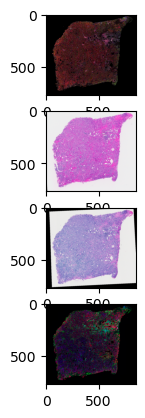

In [133]:
fig, axs = plt.subplots(nrows=len(rgbs))

for rgb, ax in zip(stacked_rgbs, axs):
    ax.imshow(rgb[::10, ::10])

Zooming in

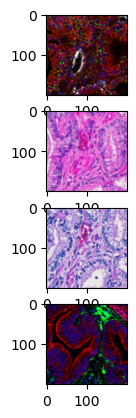

In [134]:
# taking a look at a specific tile
r1, r2, c1, c2 = 4000, 4200, 4000, 4200
fig, axs = plt.subplots(nrows=len(rgbs))

for rgb, ax in zip(stacked_rgbs, axs):
    ax.imshow(rgb[r1:r2, c1:c2])


Writing the output file that we will load into QuPath to do region annotation

In [138]:
output_fp = path_annot_dir / 'stacked_rgb.ome.tiff'

ome_model = OME(
    images=[
        Image(
            pixels=Pixels(
                dimension_order='XYCZT',
                type='uint8',
                physical_size_x_unit='µm',
                physical_size_y_unit='µm',
                physical_size_x=target_mpp * down,
                physical_size_y=target_mpp * down,
                size_c=stacked_rgbs.shape[3],
                size_t=1,
                size_x=stacked_rgbs.shape[2],
                size_y=stacked_rgbs.shape[1],
                size_z=stacked_rgbs.shape[0],
                
                channels=[
                    Channel(name=name) for name in ['r', 'g', 'b']
                ]
            )
        )
    ]
)

with tifffile.TiffWriter(output_fp, ome=True, bigtiff=True) as out_tif:
    out_tif.write(
        rearrange(stacked_rgbs, 'z y x c -> 1 z c y x'),
        compression = 'LZW'
    )
    xml_str = to_xml(ome_model)
    out_tif.overwrite_description(xml_str.encode())

In [139]:
output_fp

PosixPath('../data/registration_example/path_annotation/stacked_rgb.ome.tiff')

## Annotating a 3D path

See [this video](https://wustl.box.com/s/ml358qgb16mbykh6e0xqko0ehrw5e4ls) for instructions on how to annotate a path.

We do annotation with QuPath. When annotating keep in mind that you can scroll through the different z sections with the little scroll thing in the top left.

Also, sometimes it is possible to create "invalid" polygons when annotating. To determine whether a polygon is valid or not, click on the annotation in the annotation tab, and where it says parameter it should have an actual value, not NaN.

When exporting the annotations as a geojson at the end, make sure to select all annotations, not selected annotations (unless that is what you want).

## Loading annotated regions

We load the annotations be loading the exported geojson file from the previous step.

In [12]:
def load_regions(regions_fp, border=10):
    regions = json.load(open(regions_fp))['features']
    for x in regions:
        try:
            np.asarray(x['geometry']['coordinates'])
        except ValueError:
            rid = x['id']
            raise RuntimeError(f'{rid} failed to import. Make sure it is a valid polygon.')
            
    regions = [{
        'id': x['id'],
        'z': x['geometry']['plane']['z'] if 'plane' in x['geometry'] else 0,
        'coordinates': np.asarray(x['geometry']['coordinates']),
    } for x in regions]
    regions = [x for x in regions if len(x['coordinates'].shape) == 3]
    for x in regions:
        x['coordinates'] = x['coordinates'][0][:, [1, 0]]
        x['mask'] = skimage.draw.polygon2mask(np.asarray(target_size) // down, x['coordinates'])
        x['position'] = section_positions[x['z']]
        x['section_id'] = section_order[x['z']]

    return regions

Reading in the regions

In [13]:
regions = load_regions(path_annot_dir / 'stacked_rgb.geojson')
len(regions)

4

In [14]:
region = regions[0] # grabbing the first region
region.keys()

dict_keys(['id', 'z', 'coordinates', 'mask', 'position', 'section_id'])

You can see we have a variety of different information attached to each region

- id - region identifier
- z - z index of section that region is on
- seciont_id - section id that region is on
- position - z-depth in microns of the region
- coordinates - coordinates of the annotated polygon
- mask - a binary mask, where 1s represent pixels that are a part of the region, and 0s are background

Below I'm displaying some of the region info

In [15]:
region['id'], region['section_id'], region['z'], region['position']

('94698567-6d05-4a5e-9592-6893b9ec9e4e', 'HT891Z1-U1', 0, 0)

In [16]:
region['coordinates'].shape, region['coordinates'][:5]

((46, 2),
 array([[2996, 1299],
        [3007, 1251],
        [3057, 1183],
        [3057, 1182],
        [3058, 1182]]))

For display purposes we define a bounding box around the annotated area

In [17]:
expansion_dist = 100
r1, c1 = region['coordinates'].min(0) - expansion_dist
r2, c2 = region['coordinates'].max(0) + expansion_dist
r1, r2, c1, c2

(np.int64(2896), np.int64(3620), np.int64(1023), np.int64(1703))

In [18]:
region['mask'].shape

(7685, 8542)

Showing the mask of the annotated region

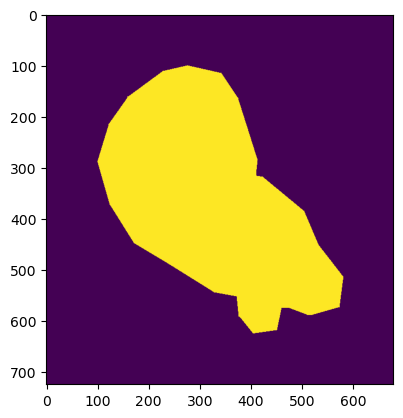

In [19]:
plt.imshow(region['mask'][r1:r2, c1:c2])

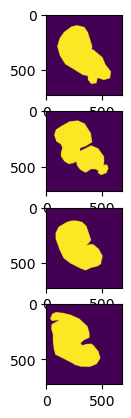

In [20]:
fig, axs = plt.subplots(nrows=len(regions))
for region, ax in zip(regions, axs):
    mask = region['mask'][r1:r2, c1:c2]
    ax.imshow(mask)

We can also display the masked region on top of the original stacked RGBs

In [36]:
# reading in the stacked RGBs that we saved earlier
stacked_rgbs = tifffile.imread(path_annot_dir / 'stacked_rgb.ome.tiff')

# tifffile unrolls the z plane, so here we are just adding it back in
stacked_rgbs = rearrange(stacked_rgbs, '(z c) h w -> z h w c', c=3)

stacked_rgbs.shape

(4, 7685, 8543, 3)

In [39]:
def get_border_ring(mask, border=10):
    ring = mask.copy()
    ring = skimage.segmentation.expand_labels(ring, distance = border)
    ring = ring ^ mask
    return ring

def add_ring_to_rgb(rgb, mask, border=10, hex_color='#ffff00'):
    color = hex_to_rgb(hex_color) * 255
    ring = get_border_ring(mask, border=border)

    rgb[ring] = color
    return rgb
    

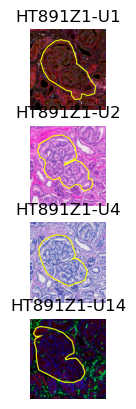

In [40]:
fig, axs = plt.subplots(nrows=len(regions))

for region, ax in zip(regions, axs):
    rgb = stacked_rgbs[region['z']].copy()
    mask = region['mask'].copy()

    rgb = rgb[r1:r2, c1:c2]
    mask = mask[r1:r2, c1:c2]

    rgb = add_ring_to_rgb(rgb, mask)

    ax.imshow(rgb)
    ax.set_title(region['section_id'])
    ax.axis('off')


## Getting expression for a region

For various analyses it is often useful to get the expression data from within an annotated region. Below I give examples of how to accomplish this for the various data types.
    

#### Multiplex

In [44]:
# the registered ome-tif
sid = 'HT891Z1-U14'
path = registered_dir / 'Z65_HT891Z1-U14_multiplex.ome.tiff'
path

PosixPath('../data/registration_example/registered/Z65_HT891Z1-U14_multiplex.ome.tiff')

In [43]:
# read multiplex image
tf = tifffile.TiffFile(path)
model = from_xml(tf.ome_metadata)
pixels = model.images[0].pixels
channel_order = [c.name for c in pixels.channels]

In [52]:
# grab the region associated with this multiplex section
region = [r for r in regions if r['section_id'] == sid][0]
mask = region['mask']

mask.shape

(7685, 8542)

We can use the mask for the region to get the average channel intensity for each channel in the multiplex image

In [55]:
values = []
for channel, page in zip(channel_order, tf.pages):
    x = page.asarray()
    x = x[::down, ::down] # we need to downscale to match the resolution of the region mask
    x = resize(x, mask.shape, preserve_range=True, anti_aliasing=False) # still might be off by a few pixels

    val = x[region['mask']].mean() # mean across region pixels

    values.append(val)

exp = pd.Series(values, index=channel_order)
exp

ERROR! Session/line number was not unique in database. History logging moved to new session 1094


DAPI                50.212328
CK14                 0.177078
LYVE1                1.535549
CD4                114.190477
CK5                  6.585530
STEAP4               0.535732
CD68                 9.363771
E-Cadherin          69.040110
SMA (D)              4.323605
CD45(D)              6.064440
p63                  0.759939
Pan-Cytokeratin     21.184314
HLA-DR              19.814268
Podoplanin           2.527934
Vimentin             3.760838
CD3e                43.108373
CD8                  0.510993
CK7                  0.046966
CD44                13.711031
Foxp3                3.871389
CD20                10.856430
Ki67                 0.914791
AR                   4.581127
AMACR                0.443137
CD31                 0.368190
dtype: float64

#### Visium HD

In [127]:
sid = 'HT891Z1-U2'
path = registered_dir / 'Z5_HT891Z1-U2_visiumhd.h5ad'
adata = sc.read_h5ad(path)
adata

AnnData object with n_obs × n_vars = 626434 × 37082
    var: 'gene_ids', 'feature_types'
    obsm: 'spatial'

In [128]:
# grab the region associated with this multiplex section
region = [r for r in regions if r['section_id'] == sid][0]
mask = region['mask']

mask.shape

(7685, 8542)

Filter the adata for only bins that occur inside the region

In [129]:
# grab x and y corrdinates, we also need to downsample to regions resolution
coords = (adata.obsm['spatial'] / down).astype(int)
xs, ys = coords[:, 0], coords[:, 1]

# filter the adata for only bins inside the region
filtered = adata[mask[ys, xs]]
filtered

View of AnnData object with n_obs × n_vars = 1468 × 37082
    var: 'gene_ids', 'feature_types'
    obsm: 'spatial'

We can now grab the average transcript count per bin

In [130]:
exp = pd.Series(filtered.X.toarray().mean(0), filtered.var.index)
exp

MIR1302-2HG                   0.0
FAM138A                       0.0
OR4F5                         0.0
AL627309.1                    0.0
AL627309.3                    0.0
                             ... 
DEPRECATED_ENSG00000278599    0.0
DEPRECATED_ENSG00000278803    0.0
DEPRECATED_ENSG00000283967    0.0
DEPRECATED_ENSG00000284873    0.0
DEPRECATED_ENSG00000285687    0.0
Length: 37082, dtype: float32

sanity check to make sure the bins we are grabbing are correct

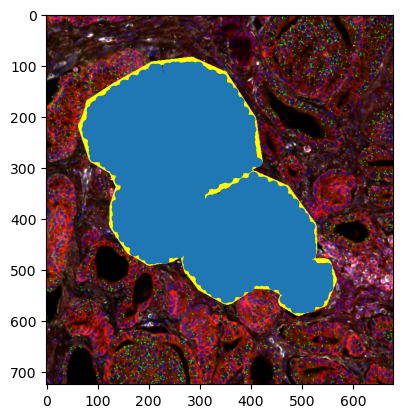

In [132]:
fig, ax = plt.subplots()

rgb = stacked_rgbs[0].copy()

rgb = rgb[r1:r2, c1:c2]
m = mask[r1:r2, c1:c2]

rgb = add_ring_to_rgb(rgb, m)

ax.imshow(rgb)

plot_coords = filtered.obsm['spatial'] / down
plot_xs, plot_ys = plot_coords[:, 0], plot_coords[:, 1]
plot_xs -= c1
plot_ys -= r1

ax.scatter(plot_xs, plot_ys)

In [70]:
# viewing some rando genes
exp[['EPCAM', 'ACTA2', 'VIM']]

EPCAM    0.215940
ACTA2    0.010218
VIM      0.032016
dtype: float32

#### Xenium

In [104]:
sid = 'HT891Z1-U1'

# cells
adata = sc.read_h5ad(registered_dir / 'Z0_HT891Z1-U1_xenium.h5ad')

# transcripts
transcripts = pd.read_parquet(registered_dir / 'Z0_HT891Z1-U1_xenium_transcripts.parquet')

In [105]:
adata

AnnData object with n_obs × n_vars = 236758 × 476
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [106]:
transcripts

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,codeword_index
0,281535106252803,UNASSIGNED,0,NKX3-1,414.988647,10421.243164,13.663547,40.000000,AB4,114.005249,461
1,281535106253271,UNASSIGNED,0,FCGR1A,910.567932,10532.438477,13.501173,40.000000,AB4,74.223717,60
2,281535106253423,UNASSIGNED,0,KRT8,1114.838013,10534.498047,12.956592,14.379375,AB4,31.147631,452
3,281535106253680,UNASSIGNED,0,CCNB2,1068.317017,10458.413086,13.203760,26.873716,AB4,41.613098,153
4,281535106253681,UNASSIGNED,0,STEAP1,1083.927490,10314.185547,13.448009,11.251747,AB4,54.231689,436
...,...,...,...,...,...,...,...,...,...,...,...
37760716,281762739590639,lfplnhmo-1,1,NTN4,34139.152344,3253.456543,16.671326,17.755287,Y15,0.000000,55
37760717,281762739597132,lfplnhmo-1,1,AMACR,34135.882812,3253.686035,17.013231,32.357807,Y15,0.000000,431
37760718,281762739600897,lfplnhmo-1,1,SEMA3C,34134.566406,3258.416504,17.176664,40.000000,Y15,0.000000,182
37760719,281762739607915,lfplnhmo-1,1,STEAP1,34126.386719,3256.484863,15.392897,35.271839,Y15,0.000000,436


In [107]:
# grab the region associated with this multiplex section
region = [r for r in regions if r['section_id'] == sid][0]
mask = region['mask'].copy()

mask.shape

(7685, 8542)

We can grab the cells in the region

In [108]:
# grab x and y corrdinates, we also need to downsample to regions resolution
coords = (adata.obsm['spatial'] / down).astype(int)
xs, ys = coords[:, 0], coords[:, 1]

# filter the adata for only cells inside the region
cell_mask = mask[ys, xs]
filtered = adata[cell_mask]
filtered.obsm['spatial'] = coords[cell_mask]
filtered

/diskmnt/Users2/estorrs/tmp/ipykernel_45736/2340740730.py:8: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  filtered.obsm['spatial'] = coords[cell_mask]


AnnData object with n_obs × n_vars = 1126 × 476
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

Plotting the cells on the region to make sure we filtered correctly

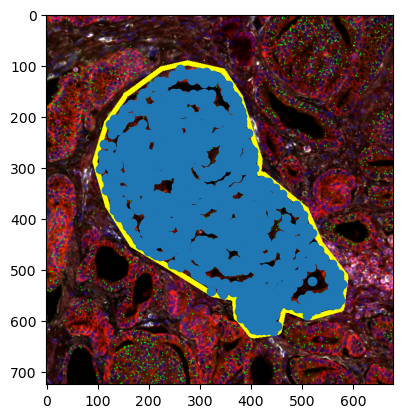

In [109]:
fig, ax = plt.subplots()

rgb = stacked_rgbs[0].copy()

rgb = rgb[r1:r2, c1:c2]
m = mask[r1:r2, c1:c2]

rgb = add_ring_to_rgb(rgb, m)

ax.imshow(rgb)

plot_coords = filtered.obsm['spatial'].copy()
plot_xs, plot_ys = plot_coords[:, 0], plot_coords[:, 1]
plot_xs -= c1
plot_ys -= r1

ax.scatter(plot_xs, plot_ys)

To get the average expression

In [110]:
exp = pd.Series(filtered.X.toarray().mean(0), filtered.var.index)
exp

ABCC11    0.001776
ACE2      0.003552
ACKR1     0.009769
ACTA2     0.071048
ACTG2     0.793073
            ...   
VCAN      0.010657
VEGFA     2.587034
VSIG4     0.004440
VWA5A     0.005329
VWF       0.089698
Length: 476, dtype: float32

We can do the same thing for the transcripts

In [111]:
# grab x and y corrdinates, we also need to downsample to regions resolution
coords = (transcripts[['x_location', 'y_location']].values / down).astype(int)
xs, ys = coords[:, 0], coords[:, 1]

# filter the transcripts for only those inside the region
transcript_mask = mask[ys, xs]
filtered = transcripts[transcript_mask]
filtered.shape

(205517, 11)

Plotting the transcripts on the region to make sure we filtered correctly

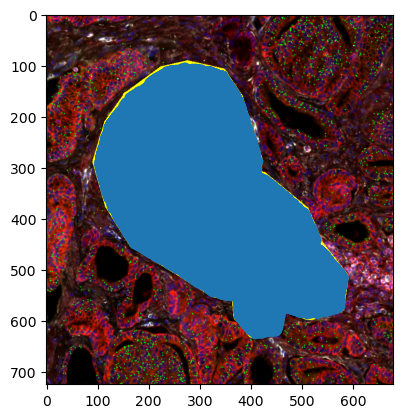

In [112]:
fig, ax = plt.subplots()

rgb = stacked_rgbs[0].copy()

rgb = rgb[r1:r2, c1:c2]
m = mask[r1:r2, c1:c2]

rgb = add_ring_to_rgb(rgb, m)

ax.imshow(rgb)

plot_coords = filtered[['x_location', 'y_location']].values / down
plot_xs, plot_ys = plot_coords[:, 0], plot_coords[:, 1]
plot_xs -= c1
plot_ys -= r1

ax.scatter(plot_xs, plot_ys)

Average number of transcripts per pixel in the region

In [115]:
filtered['feature_name'].value_counts() / np.count_nonzero(mask)

feature_name
KLK3                       0.153906
NKX3-1                     0.140727
KLK2                       0.140431
ALDH1A3                    0.110271
TMPRSS2                    0.103862
                             ...   
ASCL3                      0.000007
CD1C                       0.000007
NegControlCodeword_0518    0.000007
NegControlProbe_00034      0.000007
PPY                        0.000007
Name: count, Length: 508, dtype: float64

## Getting expression for all regions

We use the same methods for each data type above to just contain everything in 1 loop.

Here, for xenium we'll average cell expression, but you could just as easily use the transcript counts like we do above if you wanted.

In [117]:
dtype_to_expression = {k: [] for k in ['visiumhd', 'xenium', 'multiplex']}

for section_id, position in zip(section_order, section_positions):
    print(section_id)
    
    section_dtypes = set(data_map[data_map['section_id'] == section_id]['dtype'])

    section_regions = [r for r in regions if r['section_id'] == section_id]
    
    # if we are a visiumhd or xenium section
    # note we can combine these two because xenium cells and visiumhd bins are stored in the same way
    # if you wanted to count transcripts you could pull it out into a seperate elif statement
    if 'visiumhd' in section_dtypes or 'xenium' in section_dtypes:
        dtype = 'visiumhd' if 'visiumhd' in section_dtypes else 'xenium'
        path = registered_dir / f'Z{position}_{section_id}_{dtype}.h5ad'
        adata = sc.read_h5ad(path)
        
        for region in section_regions:
            mask = region['mask'].copy()
    
            # grab x and y corrdinates, we also need to downsample to regions resolution
            coords = (adata.obsm['spatial'] / down).astype(int)
            xs, ys = coords[:, 0], coords[:, 1]
            
            # filter the adata for only bins inside the region
            filtered = adata[mask[ys, xs]]
    
            # average expression
            identifier = section_id + '_' + region['id']
            exp = pd.DataFrame([filtered.X.toarray().mean(0)], columns=filtered.var.index, index=[identifier])

            dtype_to_expression[dtype].append(exp)

    # if we are a multiplex section
    elif 'multiplex' in section_dtypes:
        # read multiplex image
        path = registered_dir / f'Z{position}_{section_id}_multiplex.ome.tiff'
        tf = tifffile.TiffFile(path)
        model = from_xml(tf.ome_metadata)
        pixels = model.images[0].pixels
        channel_order = [c.name for c in pixels.channels]

        data = []
        # iterate through each channel image
        for channel, page in zip(channel_order, tf.pages):
            x = page.asarray()
            x = x[::down, ::down] # we need to downscale to match the resolution of the region mask
            x = resize(x, mask.shape, preserve_range=True, anti_aliasing=False) # still might be off by a few pixels

            values = []
            # grab average intensity for every region
            for region in section_regions:
                mask = region['mask'].copy()
        
                val = x[region['mask']].mean() # mean across region pixels
        
                values.append(val)

            data.append(values)

        identifiers = [section_id + '_' + region['id'] for region in section_regions]
        exp = pd.DataFrame(data, index=channel_order, columns=identifiers).T

        dtype_to_expression['multiplex'].append(exp)

    

HT891Z1-U1
HT891Z1-U2
HT891Z1-U4
HT891Z1-U14


Below we concatenate all the regions within each data type together

Here there is only 1 region per section for the demo, but there are usually multiple regions per data type/section depending on what you are doing.

In [123]:
# concat all the expression data frames
for k, vs in dtype_to_expression.items():
    dtype_to_expression[k] = pd.concat(vs)

In [124]:
# xenium
dtype_to_expression['xenium']

,ABCC11,ACE2,ACKR1,ACTA2,ACTG2,ADAM28,ADAM8,ADAMTS1,ADGRE1,ADGRL4,...,TUBB3,UBE2C,UCHL1,UMOD,UPK3B,VCAN,VEGFA,VSIG4,VWA5A,VWF
HT891Z1-U1_94698567-6d05-4a5e-9592-6893b9ec9e4e,0.001776,0.003552,0.009769,0.071048,0.793073,0.105684,0.060391,0.217584,0.000888,0.030195,...,0.261101,0.085258,0.003552,0.002664,0.003552,0.010657,2.587034,0.00444,0.005329,0.089698


In [125]:
# visiumhd
dtype_to_expression['visiumhd']

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,DEPRECATED_ENSG00000275663,DEPRECATED_ENSG00000276085,DEPRECATED_ENSG00000277149,DEPRECATED_ENSG00000277322,DEPRECATED_ENSG00000277556,DEPRECATED_ENSG00000278599,DEPRECATED_ENSG00000278803,DEPRECATED_ENSG00000283967,DEPRECATED_ENSG00000284873,DEPRECATED_ENSG00000285687
HT891Z1-U2_a73b04bf-55ab-44bb-914b-4351ddc5d263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000681,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
# multiplex
dtype_to_expression['multiplex']

,DAPI,CK14,LYVE1,CD4,CK5,STEAP4,CD68,E-Cadherin,SMA (D),CD45(D),...,CD3e,CD8,CK7,CD44,Foxp3,CD20,Ki67,AR,AMACR,CD31
HT891Z1-U14_591f795e-8366-4d6e-a5ed-f456b1053b52,50.212328,0.177078,1.535549,114.190477,6.58553,0.535732,9.363771,69.04011,4.323605,6.06444,...,43.108373,0.510993,0.046966,13.711031,3.871389,10.85643,0.914791,4.581127,0.443137,0.36819
